<div style="text-align: right" align="right"><i>Peter Norvig<br> Feb 2020<br>revised Jul 2025</i></div> 

# Solving Probability Problems with Monte Carlo Simulation

There are at least three distinct approaches to discrete probability problems:
- **Formula**: Apply a mathematical formula (perhaps involving [binomials](https://en.wikipedia.org/wiki/Binomial_distribution) or [combinations](https://en.wikipedia.org/wiki/Combination) or [Bayes' Rule](https://en.wikipedia.org/wiki/Bayes%27_theorem)).
- **Enumeration**: Exhaustively list all possible outcomes and add up their probabilities. I cover this in [**another notebook**](http://nbviewer.jupyter.org/url/norvig.com/ipython/Probability.ipynb).
- **Simulation**: Run a [Monte Carlo simulation](https://en.wikipedia.org/wiki/Monte_Carlo_method), in which, instead of considering all possible values for each random variable, we randomly select one outcome at each choice point, each one contingent on the previous choices, until we get a final outcome. Then we repeat the whole process *N* times to get a distribution of possible outcomes. 

# Pros of Monte Carlo Simulations

Sometimes there is no simple mathematical formula, and it is impractical, inconvenient, or even impossible to explicitly enumerate all possible outcomes. Then a simulation may be just the thing, because it is:

- **Practical**: Suppose some problem has a state space with, say, 27 variables, each with 1,000 possible values. We can't enumerate all the states on our computer, because there are more states than atoms in the universe. But we could do a simulation where we make a choice for each of the 27 variables, and repeat a million times. That's practical, and can give a good estimate of the true distribution.

- **Convenient**: The code for a simulation is simpler. You can keep track of the state of the world in ordinary programming variables, and update them with `if` and assignment statements. The code for an enumeration has to package up the state of the world into a structure, and keep track of every possible update of every possible state. Thus, a simple assignment statement in the simulation because a complex nested loop in the enumeration.

- **Possible**: Consider a game like rock-paper-scissors: it is impossible to fully enumerate the possible games, because a game can last forever (when both players continually make the same play). In a simulation an infinite game is theoretically possible, but in practice all simulated games will end fairly quickly. Or consider a game where there is an infinite number of possible moves on each turn (i.e., you can pick a real number, not just an integer). Yes, we could do tricks to make thee games finite. But in a simulation we don't have to worry about it.
 
# Cons of Monte Carlo Simulations

- **Inexactness**: A simulation gives only approximate answers. The chance of a fair coin flip coming up heads is (by definition) exactly 50%, but a simulation will in general give a slightly different answer each run, with an error that is inversely proportional to the square root of the number of trials (meaning that you need to do 100 times more trials to get 10 times more accuracy). 

- **Imbalanced data**: A problem arises when there are situations that are very rare, but very consequential.  Suppose we are simulating the flight of an airplane or the running of a power plant, and there is a very small possibility that a sequence of events could lead to a catastrophic failure. We might have to run billions of trials to see this even once, and we'd like to see it many times to get a good estimate of its probability.



# Simulating a Game: Monopoly

<img src="http://buckwolf.org/a.abcnews.com/images/Entertainment/ho_hop_go_050111_t.jpg" style="float:right">

Consider [problem 84](https://projecteuler.net/problem=84) from the excellent [Project Euler](https://projecteuler.net), which asks: in the board game Monopoly, what is the probability of ending a roll of the dice on each square on the board? Not every square will have the same probability, because chance and community chest cards direct players to specific squares, and there are multiple ways to end up on the "Jail" square.  This looks like a problem where a simulation would be a good approach. I'll define the function `monopoly(N)` to simulate a game for `N` random dice rolls and generate the squares where the player ends each roll.

I will represent the board by a list of 40 names of properties, using Project Euler's abbreviations. Squares  are represented by indexes into the board–integers from 0 to 39.    I'll implement a deck of cards (chance or community chest) as an infinite cycle of shuffled cards. Each card is either a square number (meaning go to that square), the number -3 (meaning go back three spaces), a set of square numbers (either the set of utilities or the set of railroads, meaning that we advance to the nearest utility/railroad), or `None`, meaning stay at the same square (but gain or lose some money, which this simulation does not track).


Here's the code for the simulation:

In [1]:
import matplotlib.pyplot as plt
import random
from collections import Counter
from itertools   import combinations, cycle, count as count_from
from statistics  import mean
from typing      import List, Iterable, Iterator, Callable, Tuple

In [2]:
# The Monopoly board, as specified by https://projecteuler.net/problem=84

Square  = int       # Data type for a square on the board: the square number
Board   = List[str] # Data type for board; a list of square names (not numbers)
Deck    = Iterator  # Data type for a deck of cards; you can take the `next` one.

board: Board = """
 GO    A1  CC1  A2   T1  R1  B1   CH1  B2  B3 
 JAIL  C1  U1   C2   C3  R2  D1   CC2  D2  D3  
 FP    E1  CH2  E2   E3  R3  F1   F2   U2  F3  
 G2J   G1  G2   CC3  G3  R4  CH3  H1   T2  H2""".split()    

globals().update({board[s]: s for s in range(len(board))}) # Square names are global variables

RRs = {R1, R2, R3, R4} # The 4 railroads

In [3]:
# Chance and Community Chest card decks

def deck(cards: list) -> Deck:
    """Make a deck of cards: an infinite iterable cycling through the (shuffled) cards."""
    random.shuffle(cards)
    return cycle(cards)
    
CC_cards = deck([None] * 14 + [GO, JAIL])
CH_cards = deck([None] *  6 + [GO, JAIL, C1, E3, H2, R1, RRs, RRs, {U1, U2}, -3])

def do_card(card, square: Square) -> Square:
    """Update location from `square` to new location, depending on what `card` says."""
    return (     square     if card is None                    # Don't move (card is about money)
            else square - 3 if card == -3                      # Go back 3 spaces
            else card       if isinstance(card, Square)        # Go to square named on card
            else min([s for s in card if s > square] or card)) # Advance to nearest

In [4]:
# The simulation

def monopoly(N: int) -> Iterable[Square]:
    """Simulate a Monopoly game for `N` dice rolls, yielding the squares visited."""
    square = GO                                      # Current location on board
    doubles = 0                                      # Count of consecutive doubles rolled
    for _ in range(N):
        d1, d2 = roll(), roll()                      # Roll two dice
        square = (square + d1 + d2) % len(board)     # Move ahead, maybe pass Go
        doubles = (doubles + 1 if d1 == d2 else 0)
        if square == G2J or doubles == 3: 
            square = JAIL                            # Go to Jail
            doubles = 0
        elif board[square].startswith('CC'):         # Community Chest card
            square = do_card(next(CC_cards), square)
        elif board[square].startswith('CH'):         # Chance card
            square = do_card(next(CH_cards), square)
        yield square

def roll(d=6) -> int: 
    """Random roll of a d-sided die."""
    return random.randint(1, d)

Let's run the simulation for a million rolls and look at the resulting counts of square visits:

In [5]:
P = Counter(monopoly(1_000_000))
P

Counter({9: 23042,
         17: 25898,
         22: 10376,
         27: 26773,
         35: 24422,
         3: 21704,
         19: 30994,
         26: 27071,
         32: 26113,
         12: 26086,
         10: 62259,
         15: 29294,
         24: 31746,
         31: 26721,
         0: 31009,
         4: 23348,
         13: 23671,
         21: 28515,
         14: 24621,
         23: 27259,
         5: 29258,
         36: 8789,
         6: 22708,
         11: 26968,
         38: 21831,
         28: 27853,
         33: 23602,
         39: 26357,
         1: 21215,
         18: 29451,
         20: 28791,
         16: 27738,
         29: 26122,
         25: 30728,
         34: 25102,
         2: 19087,
         8: 23233,
         37: 21658,
         7: 8587})

That will be easier to visualize as a bar chart, with square names on the x-axis. On the y-axis I want probabilities, not counts, so I will introduce the class `ProbDist` for "Probability Distribution."

In [6]:
Probability = float # Data Type for a probability, a float between 0.0 and 1.0, inclusive.

class ProbDist(Counter):
    """Probability Distribution. Like a Counter, but normalized so that values sum to 1.0."""
    def __init__(self, outcomes=()):
        super().__init__(outcomes)
        N = sum(self.values())
        for x in self:
            self[x] /= N

def monopoly_barchart(counts: Counter, board=board):
    """A bar chart of {square: probability} with names for squares."""
    plt.figure(figsize=[11, 7])
    plt.xticks(rotation=90)
    N = len(board)
    plt.plot([0, N - 1], [1/N, 1/N], 'r:') # Average value
    P_barchart(ProbDist({board[i]: counts[i] for i in range(len(board))}))

def P_barchart(P: ProbDist): 
    """A bar chart of a discrete probability distribution.""" 
    plt.xlabel("Outcomes")   
    plt.ylabel("Probability")
    plt.grid(axis='y', ls=':')
    plt.bar(P.keys(), P.values())

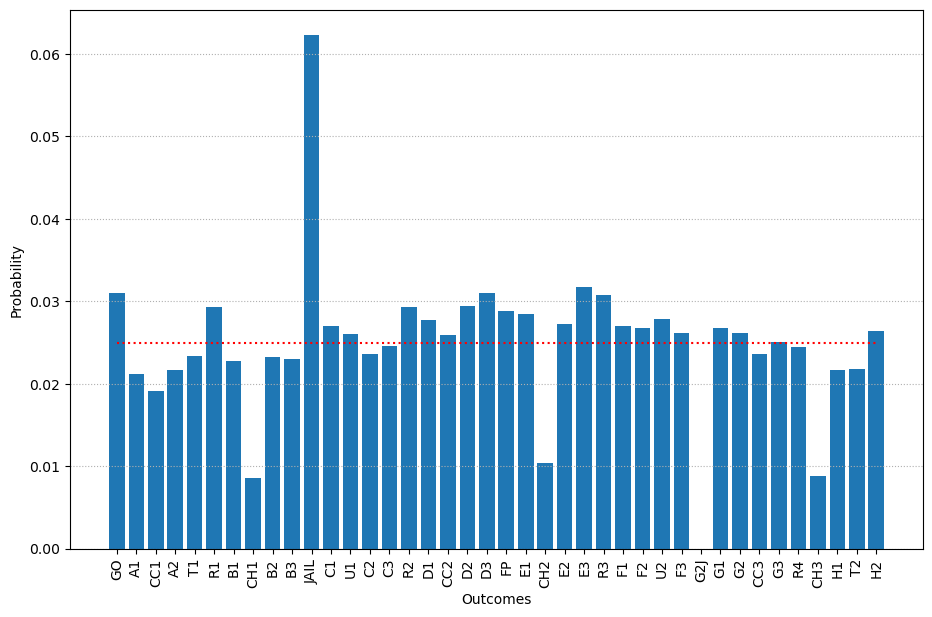

In [7]:
monopoly_barchart(P)




With 40 squares, the average is 2.5% (shown with the dotted red line), but a few squares stand out as deviating from the average:  `JAIL` is  over 6% (due to the "Go to Jail" space, the two "Go to Jail" cards, and the three-doubles rule). `E3` (Illinois Avenue) is the next most probable square, helped by a community chest card and by the fact that it is 14 spaces from jail, meaning it is the most probable place to land after two rolls out from jail. `G2J` ("Go to Jail") is 0%, because you can't end a roll there. <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/f/f1/Dice_simple_flat.svg/239px-Dice_simple_flat.svg.png" style="float:right">After that square, the three chance squares (`CH1`, `CH2`, and `CH3`) are the least probable, because 10 of the 16 chance cards send the player away from the square. The first three railroads are near 3%, helped by the chance cards, but `R4` (Short Line) is only at about 2.5%, because no chance card sends you there.

If you'd like to see another simulation, check out my [Dice Baseball](Dice%20Baseball.ipynb) notebook, or the example below:

# Simulating another Game: Roll-1


To better understand how simulations work here is another problem: a dice game (due to my friend [Cam Hewett](https://www.mathgenealogy.org/id.php?id=274478)) that I call *Roll-1*. Two players take turns rolling a single die, and the first to roll a 1 wins. The complication is that we start with a *d*-sided die, and whenever a player rolls any number other than 1, the next player's roll is with a die with that number of sides.  The function `roll_1(d)` simulates a single game (starting with a *d*-sided die) and returns the number of rolls in the game:

In [8]:
def roll_1(d=6) -> int:
    """Simulate one game of Roll-1, starting with a d-sided die; return number of rolls in the game."""
    for turn in count_from(1):
        d = roll(d)
        if d == 1:
            return turn

The function `monte_carlo` applies the Monte Carlo method, calling a simulation function *N* times and collecting a probability distribution of the results. 

In [9]:
def monte_carlo(simulation: Callable, *args, N=1_000_000) -> ProbDist:
    """Monte Carlo repetition of simulation(*args) for N trials, as a ProbDist of outcomes."""
    return ProbDist(simulation(*args) for _ in range(N))

Here is the full probability distribution of rolls (starting with a 6-sided die):

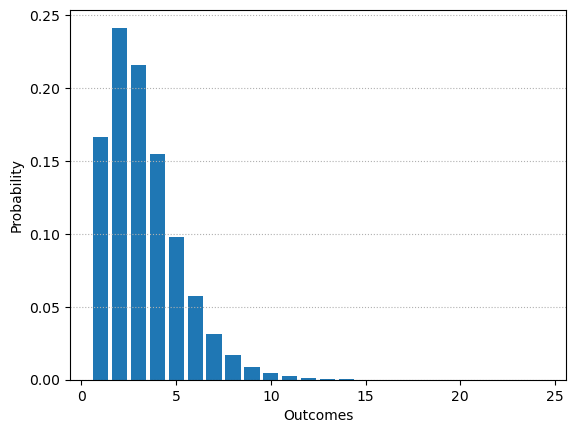

In [10]:
P6 = monte_carlo(roll_1, 6)
P_barchart(P6)

We see that 1/6th of the time the game ends on the first roll, but 2 or 3 rolls are more common, and games of 20 or more rolls do occur. We can compute the average, or expected number of rolls (by convention `E` is used for the expected value):

In [11]:
def E(P: ProbDist) -> float:
    """The expected value of a probability distribution."""
    return sum(P[x] * x for x in P)

E(P6)

3.287199

An average game takes about 3.28 rolls. 

What is the probability that the first player wins? That's the sum of the probabilities of the outcomes that have an odd number of rolls:

In [12]:
def first_player_wins(P: ProbDist) -> Probability:
    """The probability that the first player wins."""
    return sum(P[x] for x in P if x % 2 == 1)

first_player_wins(P6)

0.523025

A simulation with a million rolls should give you about 3 digits of accuracy.  If that degree of (in)accuracy is what you want, then we're done. 

# Other Approaches to Roll-1

The simulation was easy, but could we use a formula or a complete enumeration?

## Formula for Roll-1

I can give a formula for  the special  case of a 2-sided die. This is essentially a series of coin flips: on each turn there is a ½ chance of a 1 and ½ chance of a 2. The first player wins if there is an even number of 2s (zero or more) followed by a 1.  So the total probability for the first player to win is the following infinite [geometric series](https://en.wikipedia.org/wiki/Geometric_series), for which there is a [formula](https://en.wikipedia.org/wiki/Geometric_series#Formula):


$$½ + ½^3 + ½^5 + ½^7 + \ldots = a / (1 - r) = ½ / (1 - ½^2) = 2/3.$$

But if we start with a die with more than 2 sides then I don't know of a concise mathematical formula. 

## Enumerating Probabilities for Roll-1

If we could enumerate every possible game of Roll-1, we could calculate the *exact* win percentage and expected number of rolls. The bad news is that the game is **unbounded**: any number of rolls is possible, so no finite enumeration can capture every possible game. (This is sometimes called a **non-well-founded game**.)  The good news is that games with a huge number of rolls are *very unlikely*. Thus, we can enumerate every possibility for a finite, truncated version of the game, and that should give results that are very close to the full game. We will consider all possible games up to a depth of, say, 100 rolls. For a roll there are *d* possibilities. If a player rolls a 1, they win, with certainty (that's the 1.0 in the `return` statement below). For each of the die rolls from 2 to *d*, the probability that the first player wins is 1 minus the probability that the other player wins (when they become the first player in the remainder of the game). The final probability is the mean of these *d* outcomes. If we reach *depth* rolls, we truncate the game and assume that both players are equally likely to win. (This is not quite right, but since a game with over 100 rolls happens vary rarely, the overall error will be small.)

In [13]:
from functools import lru_cache

@lru_cache(None)
def roll_1_first_player_wins(d, depth=100) -> Probability:
    """The probability that the first player wins a game of Roll-1."""
    if depth == 0:
        return 1/2 # A guess
    else: # First player wins by rolling a 1, or wins with probability (1.0 - the_other_player_wins) for other rolls.
        second_player_loses = [1.0 - roll_1_first_player_wins(d1, depth - 1) for d1 in range(2, d + 1)]
        return mean([1.0, *second_player_loses])

Here are the win probabilitues for 2- and 6-sided dice:

In [14]:
roll_1_first_player_wins(2)

0.6666666666666666

In [15]:
roll_1_first_player_wins(6)

0.5238095238095237

What about computing the average length of a game? The function `roll_1_average_length` does this, using the same strategy as above.

In [16]:
@lru_cache(None)
def roll_1_average_length(d, depth=100) -> float:
    """The average length of a game of Roll-1 (truncated to `depth` moves)."""
    if depth == 0:
        return 1 # A guess
    else:
        lengths = [1 + roll_1_average_length(d1, depth - 1) for d1 in range(2, d + 1)]
        return mean([1, *lengths])

In [17]:
roll_1_average_length(2)

2.0

In [18]:
roll_1_average_length(6)

3.283333333333333

Let's try some other values of *d*, and compare the simulation approach with the exact (albeit truncated) approach:

In [19]:
def show(sides=[2, 3, 4, 5, 6, 8, 10, 12, 20, 32, 60, 100]) -> None:
    """Print information on simulated/exact game lengths and win percentages for Roll-1."""
    print('Average game length and win probability for various-sided dice, with simulated/exact calculations:\n')
    print('| sides | sim/exact length | sim/exact win % |')
    for d in sides:
        P    = monte_carlo(roll_1, d)
        avg1 = E(P)
        win1 = first_player_wins(P)
        avg2 = roll_1_average_length(d)
        win2 = roll_1_first_player_wins(d)
        print(f'| {d:5} | {avg1:6.4f} / {avg2:6.4f}  | {win1:5.2%} / {win2:5.2%} |')

show()

Average game length and win probability for various-sided dice, with simulated/exact calculations:

| sides | sim/exact length | sim/exact win % |
|     2 | 1.9996 / 2.0000  | 66.62% / 66.67% |
|     3 | 2.4994 / 2.5000  | 58.38% / 58.33% |
|     4 | 2.8334 / 2.8333  | 54.97% / 55.00% |
|     5 | 3.0863 / 3.0833  | 53.27% / 53.33% |
|     6 | 3.2836 / 3.2833  | 52.33% / 52.38% |
|     8 | 3.5968 / 3.5929  | 51.39% / 51.39% |
|    10 | 3.8279 / 3.8290  | 50.90% / 50.91% |
|    12 | 4.0177 / 4.0199  | 50.62% / 50.64% |
|    20 | 4.5431 / 4.5477  | 50.23% / 50.24% |
|    32 | 5.0285 / 5.0272  | 50.13% / 50.09% |
|    60 | 5.6703 / 5.6632  | 50.09% / 50.03% |
|   100 | 6.1799 / 6.1774  | 50.02% / 50.01% |


The simulation and exact calculations yield similar results, usually to 3 decimal places. But how exact is the "exact" calculation? There are two potential sources of error:
- Python uses 64-bit floating point numbers, with 52-bit mantissas (the part after the decimal point). That  allows for no more than 16 digits of accuracy.
- We truncate the search after *depth* rolls, taking a guess at the remaining computation.

We can measure the error lost by truncation by comparing the difference between results at  *depth* and results at deeper depths.

In [20]:
def diff(fn: Callable, d: int, depth=100, deeper=120) -> List[float]:
    """The maximum difference between fn(d, depth) and fn(d, depth2) for depth2 up to `deeper`."""
    return max(abs(fn(d, depth) - fn(d, depth2)) for depth2 in range(depth, deeper + 1))

In [21]:
[diff(roll_1_first_player_wins, d) for d in range(2, 24)]

[1.1102230246251565e-16,
 1.1102230246251565e-16,
 1.1102230246251565e-16,
 0.0,
 1.1102230246251565e-16,
 1.1102230246251565e-16,
 1.1102230246251565e-16,
 1.1102230246251565e-16,
 1.1102230246251565e-16,
 0.0,
 1.1102230246251565e-16,
 1.1102230246251565e-16,
 0.0,
 0.0,
 0.0,
 0.0,
 1.1102230246251565e-16,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [22]:
[diff(roll_1_average_length, d) for d in range(2, 24)]

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

The number 1.1102230246251565e-16 is 2<sup>-53</sup>, the smallest possible difference between two 64-bit floating point numbers (also known as the "unit in the last place" or ULP). So truncating at depth 100 leads to little or no error.

# Continuous Sample Spaces

Everything up to here has been about discrete sample spaces, where we can enumerate all the possible outcomes.

But what about *continuous* sample spaces, such as the space of real numbers? The principles are the same: probability is still the ratio of the favorable cases to all the cases. It is still easy to do a simulation. But for an exact computation, instead of *enumerating* all the discrete cases, we have to (in general) compute integrals. 
Here we will cover a simple continuous example, which we first solve approximately by simulation, and then exactly by calculation.

## The Hot New Game Show Problem: Simulation

[Oliver Roeder](https://fivethirtyeight.com/contributors/oliver-roeder/) posed [this problem](http://fivethirtyeight.com/features/can-you-win-this-hot-new-game-show/) in the 538 *Riddler* blog:

>Two players go on a hot new game show called *Higher Number Wins.* The two go into separate booths, and each presses a button, and a random number between zero and one appears on a screen. (At this point, neither knows the other’s number, but they do know the numbers are chosen from a standard uniform distribution.) They can choose to keep that first number, or to press the button again to discard the first number and get a second random number, which they must keep. Then, they come out of their booths and see the final number for each player on the wall. The lavish grand prize — a case full of gold bullion — is awarded to the player who kept the higher number. Which number is the optimal cutoff for players to discard their first number and choose another? Put another way, within which range should they choose to keep the first number, and within which range should they reject it and try their luck with a second number?

We'll use this notation:
- **A**, **B**: the two players.
- *A*, *B*: the cutoff values they choose: the lower bound of the range of first numbers they will accept.
- *a*, *b*: the actual random numbers that appear on the screen.

For example, if player **A** chooses a cutoff of *A* = 0.6, that means that **A** would accept any first number greater than 0.6, and reject any number below that cutoff. The question is: What cutoff, *A*, should player **A** choose to maximize the chance of winning, that is, maximize P(*a* > *b*)? (Since the situation is symmetric, the cutoff value *B* will be the same.)

First, simulate a single player with a given cutoff playing the game once and getting a number:

In [23]:
number = random.random

def get_number(cutoff) -> float:
    """Simulate a single player with a given cutoff receiving their number."""
    first = number()
    return first if first > cutoff else number()

We can compare two strategies: averaged over many simulated trials, how often does a player with cutoff *A* defeat a player with cutoff *B*?

In [24]:
def Pwin_sim(A, B, trials=100_000) -> Probability:
    "The probability that cutoff A wins against cutoff B."
    return mean(get_number(A) > get_number(B) for _ in range(trials))

For example,

In [25]:
Pwin_sim(0.6, 0.8)

0.52916

A cutoff of 0.6 appears to be better than a cutoff of 0.8, winning about 53% of the time.

Now define a function, `top`, that considers a list of possible cutoffs, estimates the win probability for each cutoff playing against each other cutoff, and returns a list with the `N` top cutoffs (the ones that defeated the most number of opponent cutoffs), and the number of opponents they defeat: 

In [26]:
def arange(start: float, stop: float, step: float) -> List[float]:
    """Like numpy.arange, a list of numbers from start to stop by step."""
    length = int((stop - start) / step)
    return [start + i * step for i in range(length)]

def top(N: int, Pwin_fn: Callable, cutoffs: List[float]) -> List[Tuple[float, int]]:
    "Return the N best cutoffs and the number of opponent cutoffs they beat."
    winners = Counter(A if Pwin_fn(A, B) > 0.5 else B
                      for (A, B) in combinations(cutoffs, 2))
    return winners.most_common(N)

In [27]:
top(10, Pwin_sim, arange(0.50, 1.00, .01))

[(0.58, 46),
 (0.59, 46),
 (0.6, 46),
 (0.63, 46),
 (0.62, 45),
 (0.61, 43),
 (0.56, 42),
 (0.5700000000000001, 42),
 (0.55, 41),
 (0.64, 41)]

This suggests that the best cutoff is somewhere around 0.60, but the results do not seem definitive. We could run more simulations, but that would take a lot of computation time.

## The Hot New Game Show Problem: Exact Calculation

More promising is the possibility of replacing the simulation with an exact calculation. But first let's solve a simpler problem: assume that both players **A** and **B** have chosen a cutoff, and have each received a first number that is above the cutoff. What is the probability that **A** gets the higher number? We'll call this `Phigher(A, B)`. We can think of this as a continuous two-dimensional sample space of points in the (*a*, *b*) plane, where *a* ranges from the cutoff *A* to 1 and *b* ranges from the cutoff *B* to 1. Here is a diagram of that two-dimensional sample space, with the cutoffs *A*=0.5 and *B*=0.6:

<img src="http://norvig.com/ipython/probability2da.jpg" width=413>

The total area of the sample space is 0.5 &times; 0.4 = 0.20, and in general it is (1 - *A*) &times; (1 - *B*). What about the  cases where **A** beats **B**? That corresponds to the shaded triangle below:

<img src="http://norvig.com/ipython/probability2d.jpg" width=413>

The area of a triangle is 1/2 the base times the height, or in this case, 0.4<sup>2</sup> / 2 = 0.08, and in general, (1 - *B*)<sup>2</sup> / 2. So in general we have:

    Phigher(A, B) = favorable / total
    favorable     = ((1 - B) ** 2) / 2 
    total         = (1 - A) * (1 - B)
    Phigher(A, B) = (((1 - B) ** 2) / 2) / ((1 - A) * (1 - B))
    Phigher(A, B) = (1 - B) / (2 * (1 - A))
    
And in this specific case we have:

     A = 0.5; B = 0.6
     favorable         = 0.4 ** 2 / 2 = 0.08
     total             = 0.5 * 0.4    = 0.20
     Phigher(0.5, 0.6) = 0.08 / 0.20  = 0.4

But note that this only works when the cutoff *A* &le; *B*; when *A* > *B*, we need to reverse things. That gives us the code:

In [28]:
def Phigher(A, B):
    """Probability that a sample from [A..1] is higher than one from [B..1]."""
    if A <= B:
        return (1 - B) / (2 * (1 - A))
    else:
        return 1 - Phigher(B, A)

In [29]:
assert Phigher(0.5, 0.6) == 0.4

We're now ready to tackle the full game. There are four cases to consider, depending on whether **A** and **B** gets a first number that is above or below their cutoff choices:

| first *a* | first *b* | P(*a*, *b*) | P(A wins &vert; *a*, *b*) |  Comment |
|:-----:|:-----:| ----------- | ------------- | ------------ |
| *a* > *A* | *b* > *B* | (1 - *A*) &middot; (1 - *B*) | Phigher(*A*, *B*) | Both above cutoff; both keep first numbers |
| *a* < *A* | *b* < *B* | *A* &middot; *B* | Phigher(0, 0)  | Both below cutoff, both get new numbers from [0..1] |
| *a* > *A* | *b* < *B* | (1 - *A*) &middot;  *B* | Phigher(*A*, 0) | **A** keeps number; **B** gets new number from [0..1] |
| *a* < *A* | *b* > *B* | *A* &middot; (1 - *B*) | Phigher(0, *B*) | **A** gets new number from [0..1]; **B** keeps number |

For example, the first row of this table says that the event of both first numbers being above their respective cutoffs has probability (1 - *A*) &middot; (1 - *B*), and if this does occur, then the probability of **A** winning is Phigher(*A*, *B*).
We're ready to replace the old simulation-based `Pwin_sim` with a new exact version, `Pwin_exact`:

In [30]:
def Pwin_exact(A, B):
    "With what probability does cutoff A win against cutoff B?"
    return ((1-A) * (1-B) * Phigher(A, B)  # both above cutoff
            + A * B       * Phigher(0, 0)  # both below cutoff
            + (1-A) * B   * Phigher(A, 0)  # A above, B below
            + A * (1-B)   * Phigher(0, B)) # A below, B above

In [31]:
Pwin_exact(0.6, 0.8)

0.528

We see that the 0.6 cutoff beats 0.8 52.8% of the time.

`Pwin_exact` relies on a lot of algebra. Let's define a few tests to check for obvious errors:

In [32]:
def test():
    assert Phigher(0.5, 0.5) == Phigher(0.75, 0.75) == Phigher(0, 0) == 0.5
    assert Pwin_exact(0.5, 0.5) == Pwin_exact(0.75, 0.75) == 0.5
    assert Phigher(.6, .5) == 0.6
    assert Phigher(.5, .6) == 0.4
    return 'ok'

test()

'ok'

Let's repeat the `top` calculation with `Pwin_exact`:

In [33]:
top(10, Pwin_exact, arange(0.5, 1.0, 0.01))

[(0.62, 49),
 (0.61, 48),
 (0.6, 47),
 (0.59, 46),
 (0.63, 45),
 (0.58, 44),
 (0.5700000000000001, 43),
 (0.64, 42),
 (0.56, 41),
 (0.55, 40)]

We see here that of the 50 candidate cutoffs, 0.62 defeats all the other 49, and 0.61 defeats 48 (all except 0.62). The great thing about the exact calculation code is that it runs fast, regardless of how much accuracy we want. We can zero in on those top ten cutoffs, 0.55 to 0.64, and go to 4 digits:

In [34]:
top(10, Pwin_exact, arange(0.55, 0.64, 0.0001))

[(0.6180000000000001, 898),
 (0.6179, 897),
 (0.6181000000000001, 896),
 (0.6178, 895),
 (0.6177, 894),
 (0.6176, 893),
 (0.6182000000000001, 892),
 (0.6175, 891),
 (0.6174000000000001, 890),
 (0.6183000000000001, 889)]

This says 0.6180 is best. Let's go to 6 digits:

In [35]:
top(10, Pwin_exact, arange(0.6174, 0.6183, 0.000001))

[(0.618034, 899),
 (0.6180329999999999, 898),
 (0.6180319999999999, 897),
 (0.618035, 896),
 (0.618031, 895),
 (0.61803, 894),
 (0.6180289999999999, 893),
 (0.6180359999999999, 892),
 (0.6180279999999999, 891),
 (0.618027, 890)]

Now 0.618034 is best. I'll leave it up to you to explore whether the exact answer is actually a [well-known irrational number](https://en.wikipedia.org/wiki/Golden_ratio).

So far we've been hunting around in the space of possible cutoffs, trying to find the best one, but we can make a stronger argument. Suppose the game is changed so that player **A** has to declare a cutoff first, and then player **B** gets to respond with their cutoff, with full knowledge of **A**'s choice. In other words, what cutoff should **A** choose to **maximize** `Pwin_exact(A, B)`, given that **B** is going to take that knowledge and pick a cutoff that **minimizes** `Pwin_exact(A, B)`? 

We can consider a wide range of cutoffs, with some that zero in on the interval around 0.618034.

In [36]:
cutoffs = list(arange(0.000, 1.000, 0.001)) + list(arange(0.618030, 0.618040, 0.000001))

I'll use this helper function:

In [37]:
def Pwin(A, B): return (Pwin_exact(A, B), f'probability of winning for A with A={A}, B={B}')

Here is the final winning percentage for **A** along with the best choice of cutoffs *A* and *B*, when **A** declares their cutoff first:

In [38]:
max(min(Pwin(A, B) for B in cutoffs)
    for A in cutoffs)

(0.5, 'probability of winning for A with A=0.618034, B=0.618034')

And here it is the other way around, when **B** has to declare their cutoff first:

In [39]:
min(max(Pwin(A, B) for A in cutoffs)
    for B in cutoffs)

(0.5, 'probability of winning for A with A=0.618034, B=0.618034')

In both cases, the rational choice for both players in a cutoff of 0.618034. This is a *stable equilibrium*: consider fixing *B* = 0.618034, and notice that if *A* changes to any other cutoff value, player **A** does worse. Similarly, if we fix *A* = 0.618034, then if *B* changes to another value, player **B** does worse. So neither player will want to move.

The moral for continuous spaces is the same as for discrete spaces: be careful about defining your sample space; measure carefully, and let your code take care of the rest.